In [64]:
from fastspt import simulate, fit2, tracklen, version
import numpy as np
import logging

logging.basicConfig(level=logging.INFO)
%matplotlib inline

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
version.__version__

'19.0-dev'

# 1. Simulation tools

`simulate` module implements 2-state model simulations

## Single track

In [5]:
# Default parameters
simulate.track(track_id=0,
    start_time=0,
    dt=0.06,
    D_bound=0.02,
    D_free=0.06,
    loc_error=0.02,
    p_binding=0.0001,
    p_unbinding=0.001,
    p_bleaching=0.1,
    p_out_of_focus=0.01,
    min_len=5,
)

     x [um]    y [um]  t [sec]  frame []  sigma [um]  free []  id []
0 -0.145945 -0.063614     0.00       0.0    0.023855      1.0    0.0
1 -0.116084 -0.004887     0.06       1.0    0.023535      1.0    0.0
2 -0.035694 -0.042775     0.12       2.0    0.019106      1.0    0.0
3 -0.066660  0.115326     0.18       3.0    0.018303      1.0    0.0
4  0.076568  0.118940     0.24       4.0    0.017506      1.0    0.0
5  0.013915  0.158296     0.30       5.0    0.022998      1.0    0.0
6 -0.028926  0.205474     0.36       6.0    0.014162      1.0    0.0

## List of tracks

In [106]:
p_bleaching=0.1
tracks = simulate.tracks(
    num_tracks=1000.0,
    dt=0.06,
    D_bound=0.0,
    D_free=0.05,
    loc_error=0.02,
    p_binding=0.0001,
    p_unbinding=0.001,
    p_bleaching=p_bleaching,
    p_out_of_focus=1e-05,
    min_len=10,
    use_tqdm=True,)

INFO:fastspt.simulate:Simulating 1000.0 tracks


In [107]:
len(tracks)

1000

INFO:fastspt.tracklen:1000 tracks, 19782 localizations
INFO:fastspt.tracklen:Fit result: 328 * e^(-0.11x)


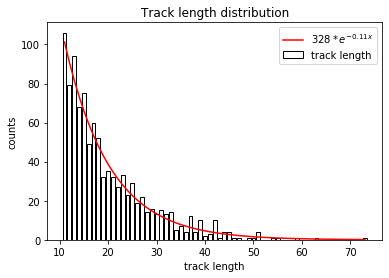

In [108]:
len_fit = tracklen.get_track_lengths_dist(tracks,)

In [105]:
np.testing.assert_almost_equal(len_fit, p_bleaching, decimal=-np.log10(p_bleaching))

# 2. Fit kinetics

INFO:fastspt.fit2:fit_spoton_2_0: Fit path: None, fit_D: (True, True)
INFO:fastspt.fit2:Total 1000 tracks
INFO:fastspt.fit2:fit_spoton_2_0: Plot fit for (D, F): (array([0.        , 0.05168663]), array([0.09931269, 0.90068731])),             1 lags


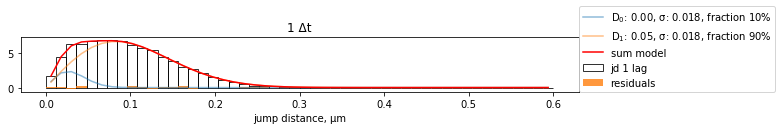

In [63]:
# fit one lag (1 Δt)
fit = fit2.fit_spoton_2_0(tracks)

In [11]:
fit

{'sigma': [0.019398657596761484],
 'D': [0.0, 0.05058330126984312],
 'F': [0.08528088996217825, 0.9147191100378218],
 'dt': 0.06,
 'n_tracks': 10000,
 'chi2': 0.07603272544596144,
 'chi2_norm': 0.0015206545089192288,
 'n_iter': 31,
 'path': None}

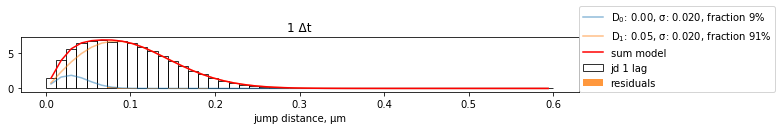

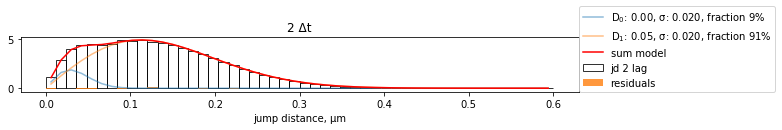

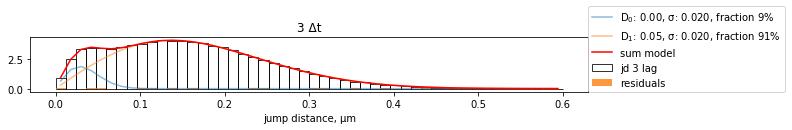

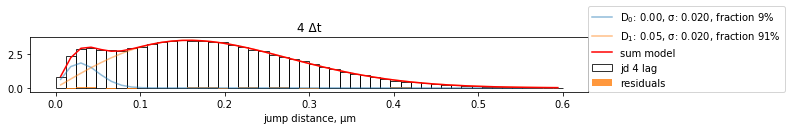

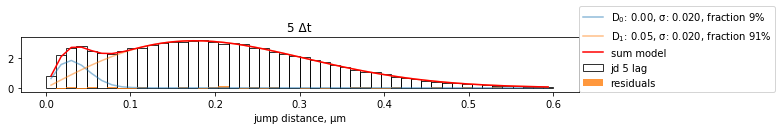

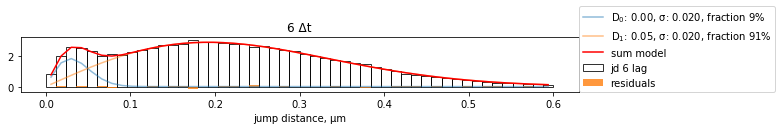

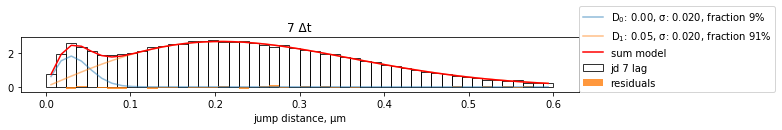

In [14]:
# fit 5 lags (1..5 Δt)

fit = fit2.fit_spoton_2_0(tracks, n_lags=7, return_fit_result=1, D=(0.05, 0.5), n_bins=50, max_um=0.6)

In [15]:
fit['fit_result']

## simulate and fit 3 states

In [16]:
tracks_3_states = simulate.tracks(D_free=0.04) + simulate.tracks(D_free=0.01)

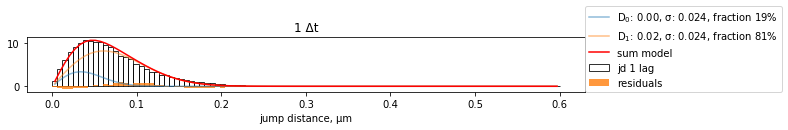

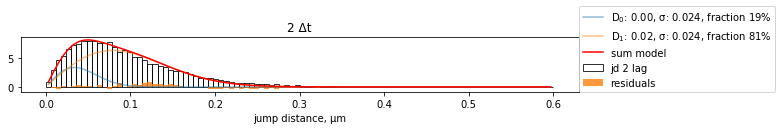

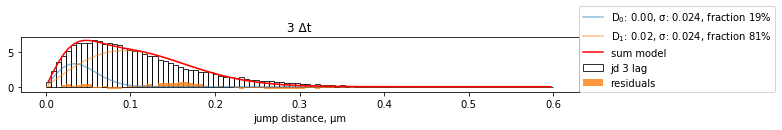

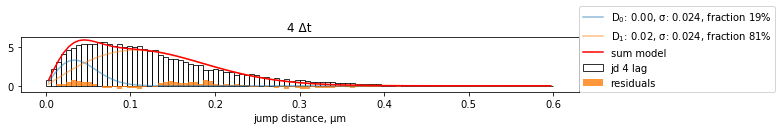

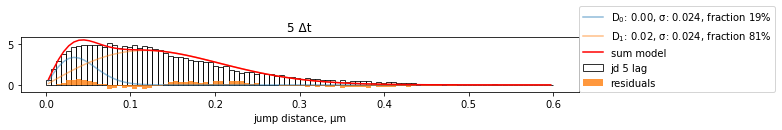

In [17]:
#first try 2-state fit
fit_2_states = fit2.fit_spoton_2_0(tracks_3_states, n_lags=5, n_bins=100)

In [18]:
fit_2_states['chi2']

32.905939289148506

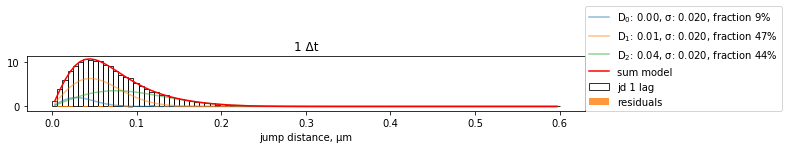

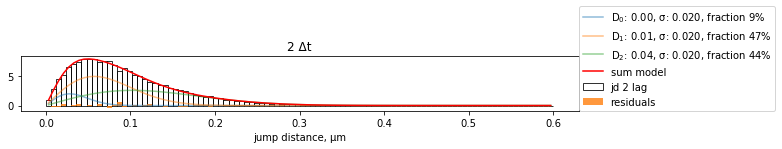

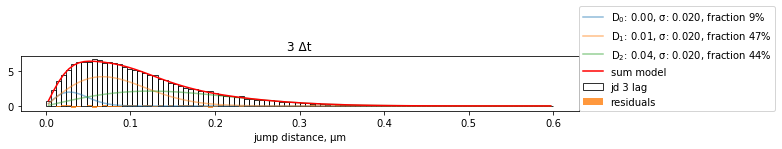

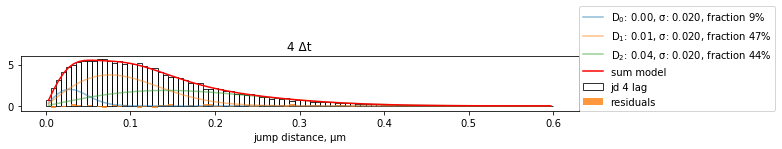

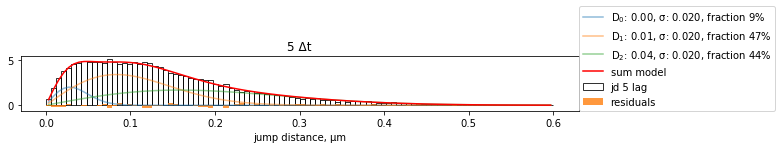

In [19]:
# Try 3-states fit

fit_3_states = fit2.fit_spoton_2_0(
    tracks_3_states, 
    n_lags=5, 
    n_bins=100,
    D=(0,0.05,0.2),
    fit_D=(1,1,1,),
    F=(0.3,0.3,0.4),
    fit_F=(1,1,1)
)

In [20]:
fit_3_states['chi2']

5.041627618592502

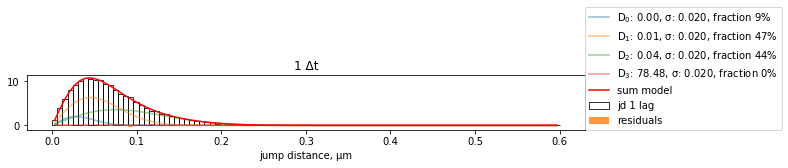

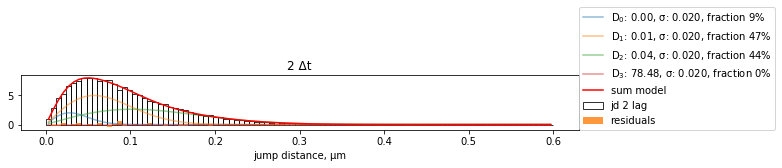

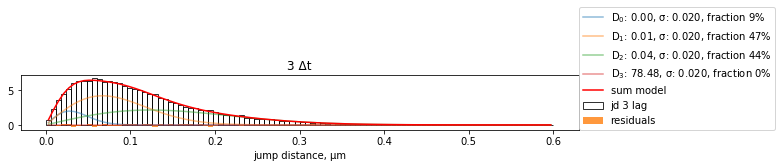

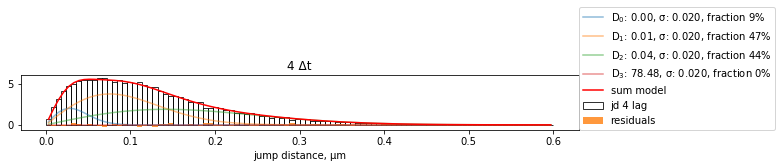

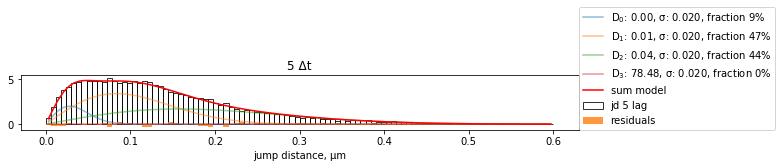

In [21]:
# 4 states, maybe?? Why not!


fit_4_states = fit2.fit_spoton_2_0(
    tracks_3_states, 
    n_lags=5, 
    n_bins=100,
    D=(0,0.01,0.2,0.3),
    fit_D=(1,1,1,1),
    F=(0.3,0.3,0.2,0.2),
    fit_F=(1,1,1,1)
)

In [22]:
fit_4_states

{'sigma': [0.019857755069429224],
 'D': [0.0, 0.01025167088764034, 0.04007692146304387, 78.4774174727437],
 'F': [0.09296470592485878,
  0.46642395753273796,
  0.43928939932494926,
  0.001321937217453939],
 'dt': 0.06,
 'n_tracks': 2000,
 'chi2': 5.037703873187275,
 'chi2_norm': 0.01007540774637455,
 'n_iter': 243,
 'path': None}

In [23]:
fit_4_states['chi2']

5.037703873187275

In [24]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Fit of 3-states simulated data')

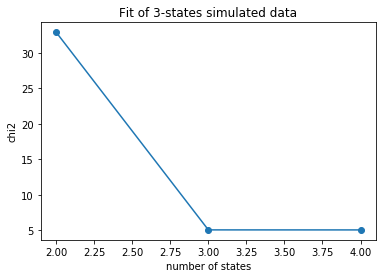

In [25]:
all_fits = [fit_2_states, fit_3_states, fit_4_states]
chi2s = [f['chi2'] for f in all_fits]
n_states = [len(f['D']) for f in all_fits]
plt.plot(n_states, chi2s, 'o-')
plt.xlabel('number of states')
plt.ylabel('chi2')
plt.title('Fit of 3-states simulated data')


## Test the speed

In [27]:
# simulate 10 2-states datasets 
data = [simulate.tracks(num_tracks=1e3, D_bound=0.0, D_free=0.05, use_tqdm=False) for _ in fit2.tqdm(range(10))]

In [28]:
fits = [fit2.fit_spoton_2_0(d, D=(0., .1),plot=False, n_lags=1, max_um=0.5, n_bins=50) for d in fit2.tqdm(data)]

In [29]:
fit2.result_2_table(*fits)

,sigma_0,D_0,D_1,F_0,F_1,dt,n_tracks,chi2,chi2_norm,n_iter
replicate,,,,,,,,,,
0,0.019786,0.0,0.050779,0.104552,0.895448,0.06,1000,0.425607,0.008512,26
1,0.019673,0.0,0.050113,0.083410,0.916590,0.06,1000,0.678052,0.013561,36
2,0.020754,0.0,0.051080,0.085100,0.914900,0.06,1000,0.609460,0.012189,36
3,0.019448,0.0,0.049786,0.084751,0.915249,0.06,1000,0.827993,0.016560,31
4,0.018902,0.0,0.048819,0.063716,0.936284,0.06,1000,0.569603,0.011392,36
5,0.019363,0.0,0.050604,0.093731,0.906269,0.06,1000,0.407509,0.008150,36
6,0.021363,0.0,0.049585,0.086957,0.913043,0.06,1000,0.389276,0.007786,31
7,0.021740,0.0,0.048710,0.081642,0.918358,0.06,1000,0.580215,0.011604,31
8,0.019565,0.0,0.049747,0.074242,0.925758,0.06,1000,0.550628,0.011013,31


In [30]:
# 2 unbound states
print('simulate 10 datasets')
data = [simulate.tracks(num_tracks=4e3, D_bound=0.05, D_free=0.5, use_tqdm=False) for _ in fit2.tqdm(range(10))]

simulate 10 datasets


In [31]:
# dibabling plot dramatically improves performance!
print('start fit')
fits = [fit2.fit_spoton_2_0(d, D=(0.2, 1),plot=False, n_lags=7, max_um=2, n_bins=50, return_fit_result=True) for d in fit2.tqdm(data)]

start fit


In [32]:
table = fit2.result_2_table(*fits)
table.loc['mean'] = table.mean(0)
table.loc['std'] = table.std(0)
table

,sigma_0,D_0,D_1,F_0,F_1,dt,n_tracks,chi2,chi2_norm,n_iter
replicate,,,,,,,,,,
0,0.025526,0.020775,0.500052,0.100063,0.899937,6.000000e-02,4000.0,0.094199,0.000269,41.000000
1,0.019601,0.021466,0.492160,0.083090,0.916910,6.000000e-02,4000.0,0.101715,0.000291,41.000000
2,0.022591,0.020569,0.500824,0.087468,0.912532,6.000000e-02,4000.0,0.096263,0.000275,54.000000
3,0.021645,0.021537,0.497810,0.098137,0.901863,6.000000e-02,4000.0,0.113228,0.000324,47.000000
4,0.024878,0.019643,0.496886,0.099183,0.900817,6.000000e-02,4000.0,0.113401,0.000324,41.000000
5,0.023008,0.020350,0.504695,0.093184,0.906816,6.000000e-02,4000.0,0.108113,0.000309,74.000000
6,0.021693,0.020282,0.500899,0.092954,0.907046,6.000000e-02,4000.0,0.108953,0.000311,41.000000
7,0.023048,0.020290,0.503449,0.101425,0.898575,6.000000e-02,4000.0,0.087532,0.000250,43.000000
8,0.022137,0.020857,0.504892,0.095843,0.904157,6.000000e-02,4000.0,0.089853,0.000257,41.000000


In [33]:
# simulate unbound molecules
tracks = simulate.tracks(D_bound=0.05, D_free=0.5, num_tracks=4e3)

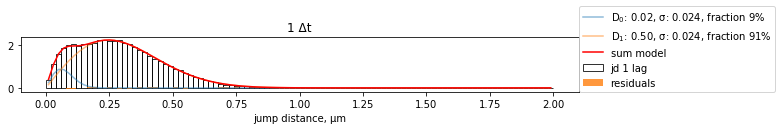

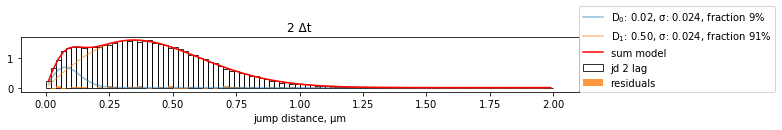

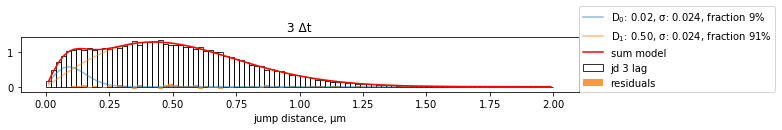

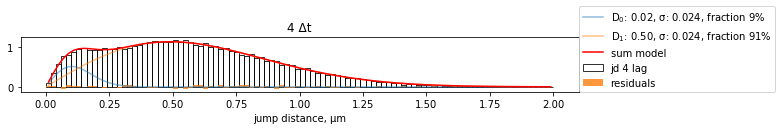

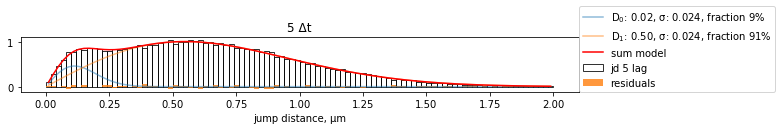

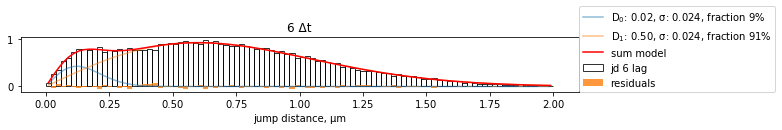

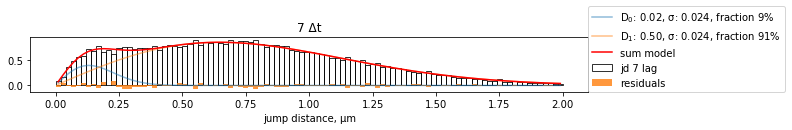

{'sigma': [0.024007714963759395],
 'D': [0.019046179074453162, 0.49701706411206303],
 'F': [0.08593857902330176, 0.9140614209766982],
 'dt': 0.06,
 'n_tracks': 4000,
 'chi2': 0.37489140908747526,
 'chi2_norm': 0.0005355591558392504,
 'n_iter': 42,
 'path': None}

In [34]:
fit2.fit_spoton_2_0(tracks, D=(0.1, 1), max_um=2, n_bins=100, n_lags=7)

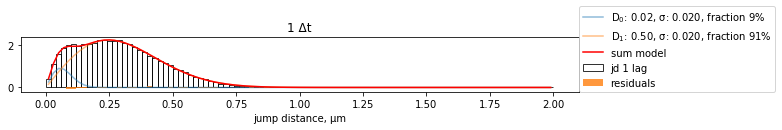

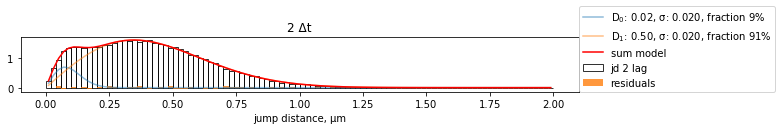

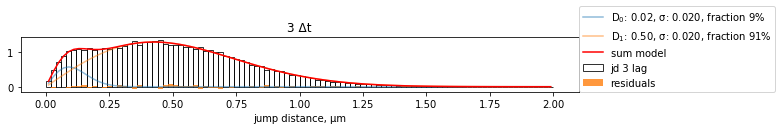

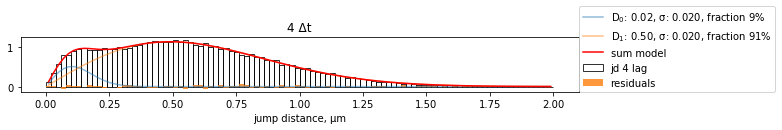

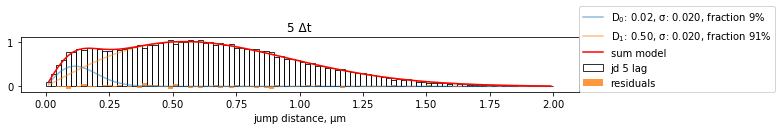

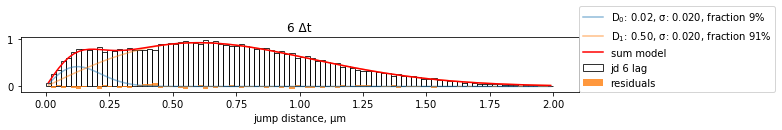

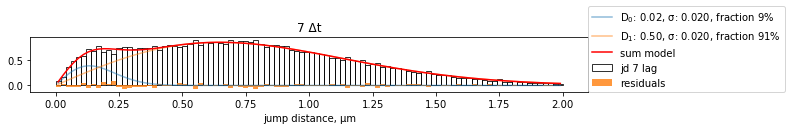

{'sigma': [0.02],
 'D': [0.020201307446218397, 0.49821854510772723],
 'F': [0.08578140068828427, 0.9142185993117158],
 'dt': 0.06,
 'n_tracks': 4000,
 'chi2': 0.3822778390282079,
 'chi2_norm': 0.0005461111986117255,
 'n_iter': 34,
 'path': None}

In [35]:
# fix sigma
fit2.fit_spoton_2_0(tracks, D=(0.1, 1), max_um=2, n_bins=100, n_lags=7, sigma=(0.02,), fit_sigma=(False,))